In [626]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-data/finWeatherData.csv
/kaggle/input/power-demand-data/demand_Data.csv


In [627]:
df_weather =  pd.read_csv("/kaggle/input/weather-data/finWeatherData.csv",index_col = 0,parse_dates=True)

In [628]:
df_weather.head()

,Date,Tmax,Tmin,Rain
0,2019-01-01,28.696802,14.070121,0.0
1,2019-01-02,29.149151,14.778795,0.0
2,2019-01-03,29.741541,15.863366,0.0
3,2019-01-04,29.451434,16.492335,0.0
4,2019-01-05,28.863384,16.951641,0.0


In [629]:
df_demand = pd.read_csv("/kaggle/input/power-demand-data/demand_Data.csv",parse_dates =True)

In [630]:
df_demand.head()

,Date,Energy Required (MU)
0,02-May-12,255.639
1,03-May-12,258.470
2,04-May-12,261.393
3,05-May-12,252.866
4,06-May-12,250.566


In [631]:

# Convert the date column to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'],errors="coerce", format="%d-%b-%y")

# Convert the date column to the desired format
df_demand['Date'] = df_demand['Date'].dt.strftime("%d/%m/%Y")

In [632]:
import pandas as pd

# Convert the "Date" column in df_energy to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'])

# Filter df_energy to include dates starting from 01/01/2019
df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Convert the "Date" column in df_weather to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Filter df_weather to include dates starting from 01/01/2019
df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Merge the two DataFrames based on the "Date" column
merged_df = pd.merge(df_demand, df_weather, on='Date', how='inner')


/tmp/ipykernel_32/3321147370.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_demand['Date'] = pd.to_datetime(df_demand['Date'])


In [633]:
merged_df

,Date,Energy Required (MU),Tmax,Tmin,Rain
0,2019-01-01,152.233,28.696802,14.070121,0.000000
1,2019-02-01,155.343,29.408003,18.148469,0.000000
2,2019-03-01,157.659,33.184526,23.714411,1.550007
3,2019-04-01,159.317,37.308186,25.592237,0.025442
4,2019-05-01,159.691,36.672354,27.560249,1.480898
...,...,...,...,...,...
1553,2023-03-05,188.591,35.240079,19.384070,0.000000
1554,2023-04-05,193.000,35.972310,25.309858,0.392332
1555,2023-05-05,193.201,33.934335,25.928193,2.541572
1556,2023-05-13,224.030,38.145824,27.398606,0.000000


In [634]:
merged_df = merged_df.set_index("Date")

In [635]:
merged_df.isna().sum()

Energy Required (MU)    0
Tmax                    0
Tmin                    0
Rain                    0
dtype: int64

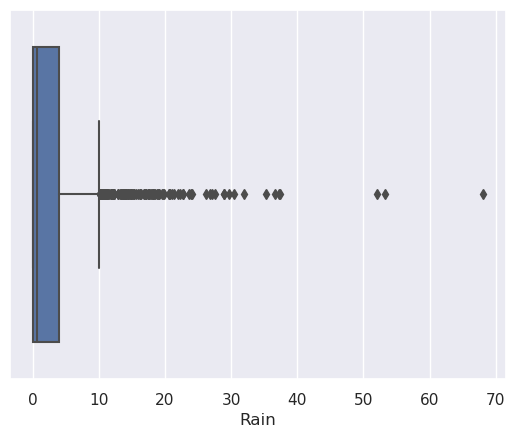

In [636]:
sns.boxplot(x=merged_df['Rain'])
plt.show()

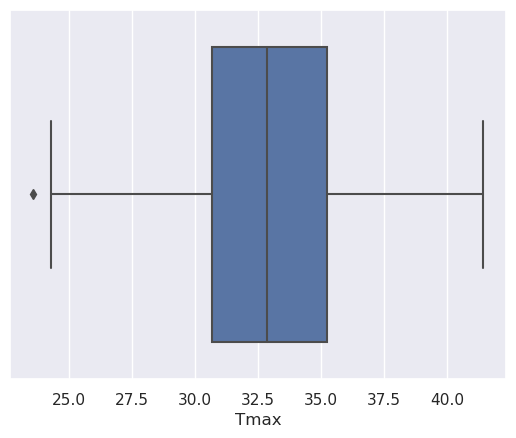

In [637]:
sns.boxplot(x=merged_df['Tmax'])
plt.show()

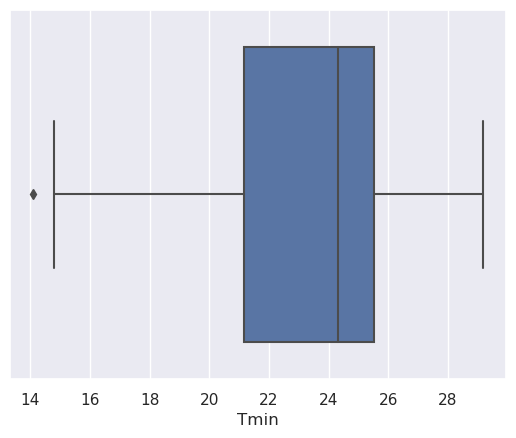

In [638]:
sns.boxplot(x=merged_df['Tmin'])
plt.show()

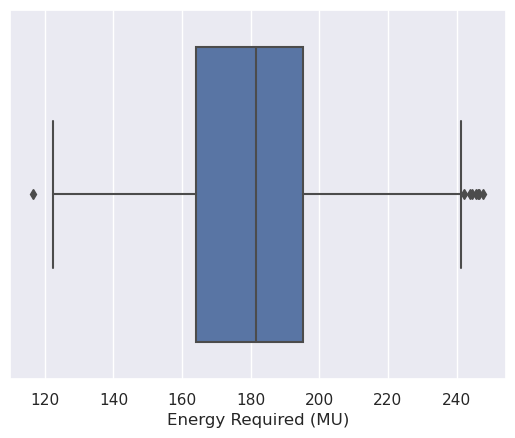

In [639]:
sns.boxplot(x=merged_df['Energy Required (MU)'])
plt.show()

In [640]:
# Convert index to a DatetimeIndex with a frequency
merged_df.index = pd.date_range(start=merged_df.index[0], periods=len(merged_df), freq='D')

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

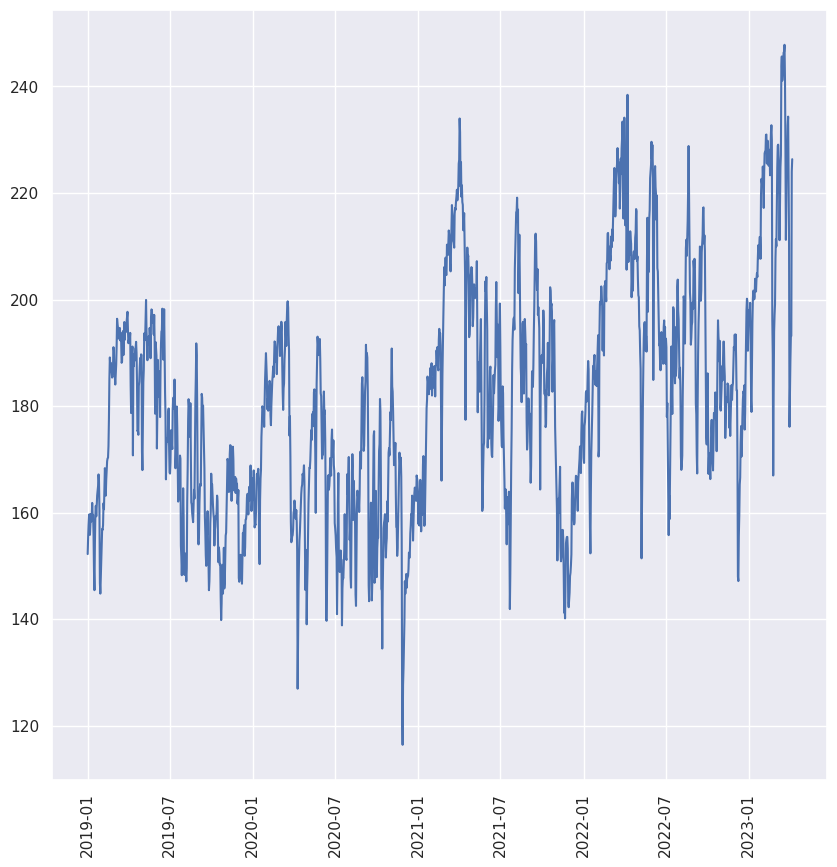

In [641]:
plt.figure(figsize=(10,10))
plt.plot(merged_df["Energy Required (MU)"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

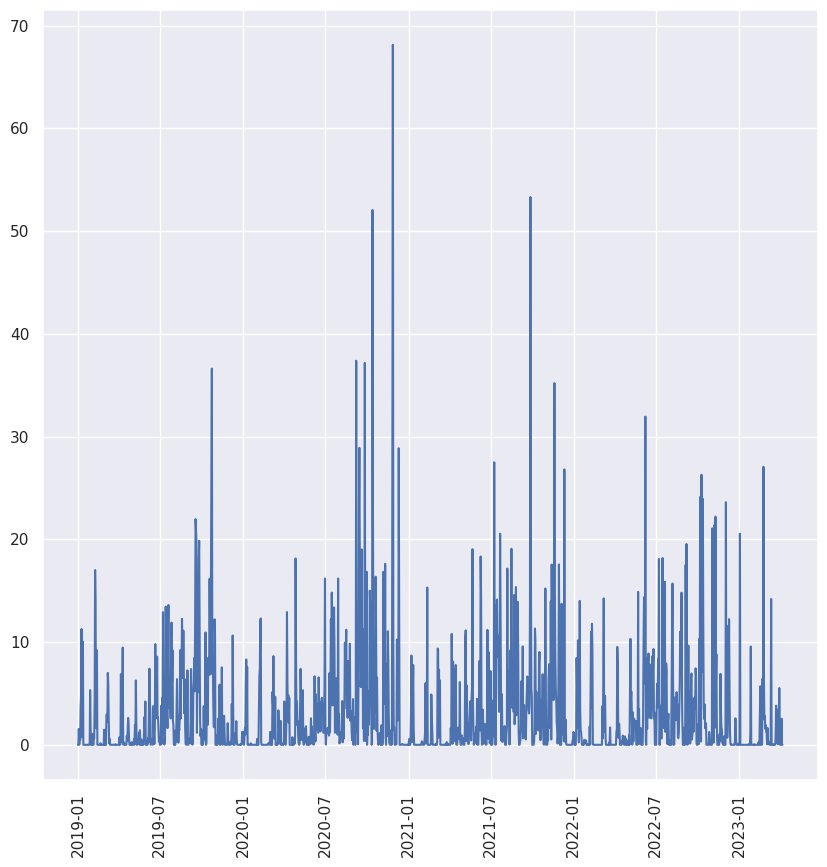

In [642]:
plt.figure(figsize=(10,10))
plt.plot(merged_df["Rain"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

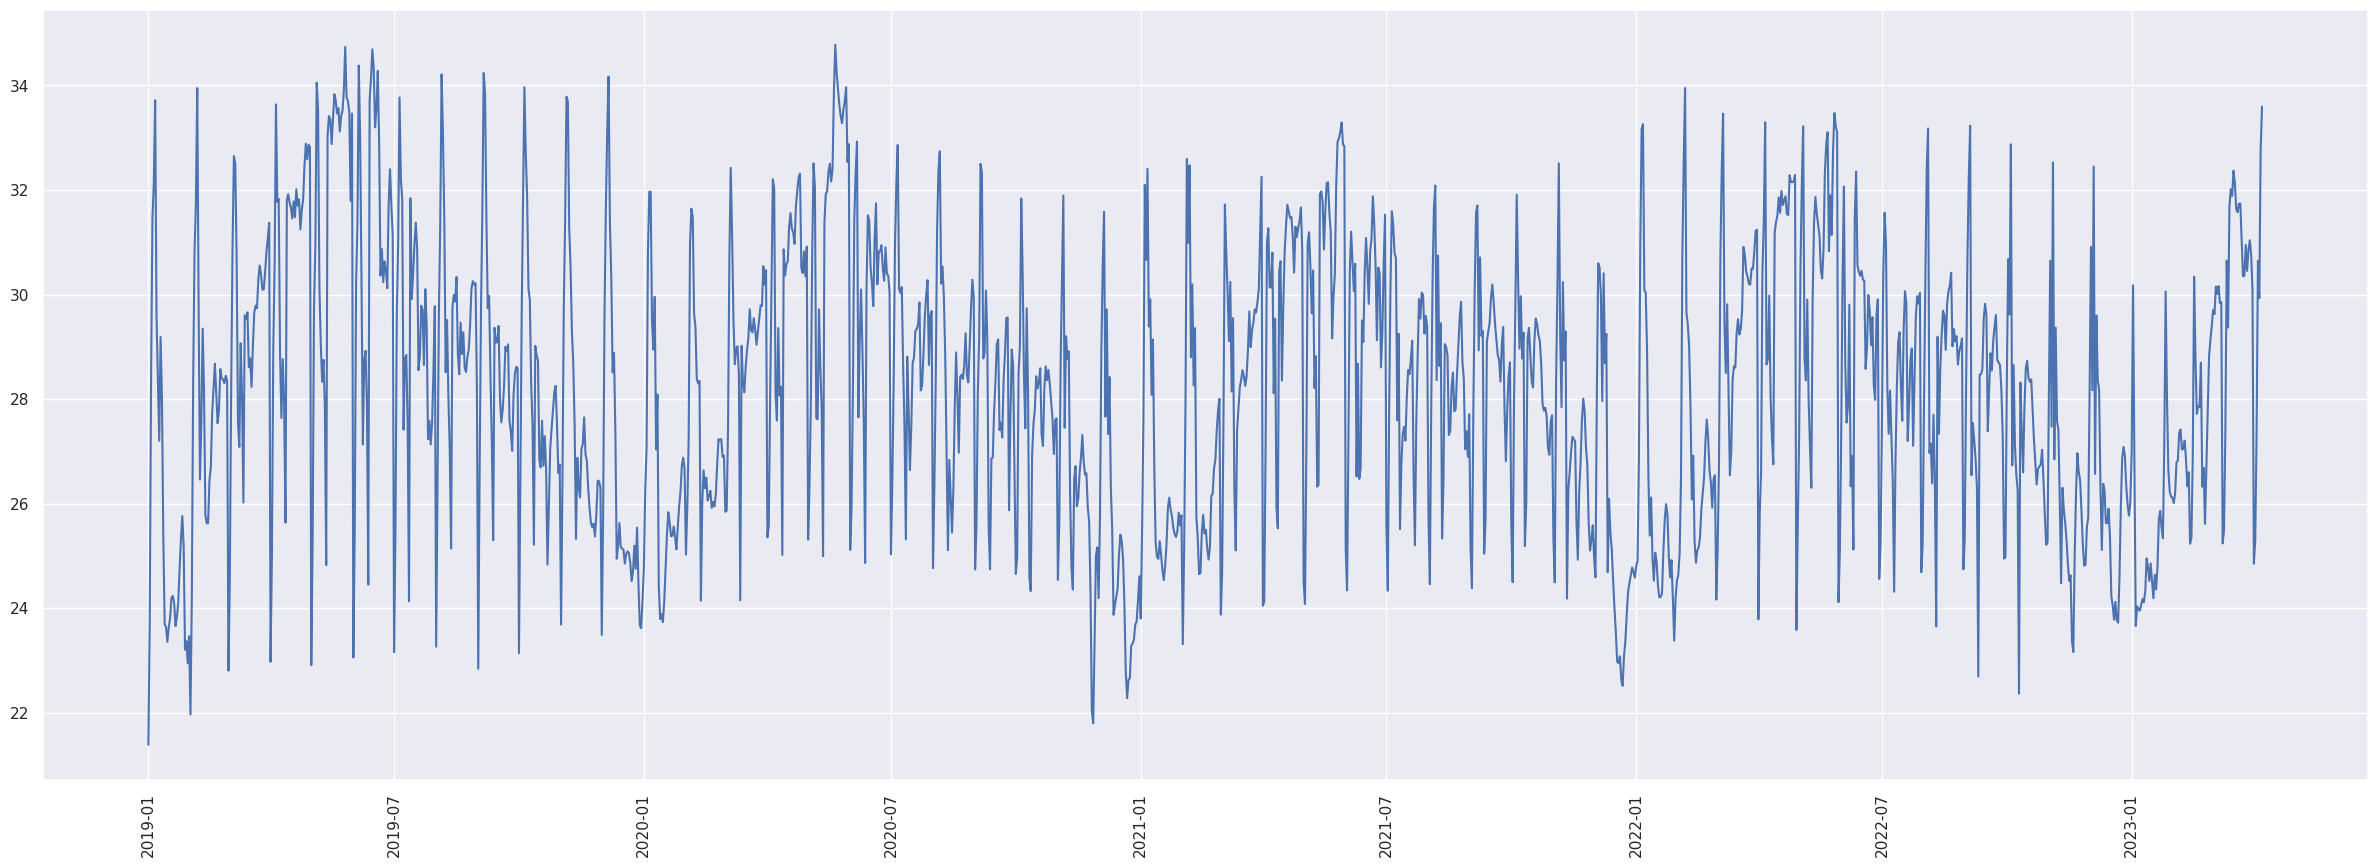

In [643]:
plt.figure(figsize=(30,10))
plt.plot((merged_df["Tmax"]+merged_df["Tmin"])/2)
plt.xticks(rotation=90)

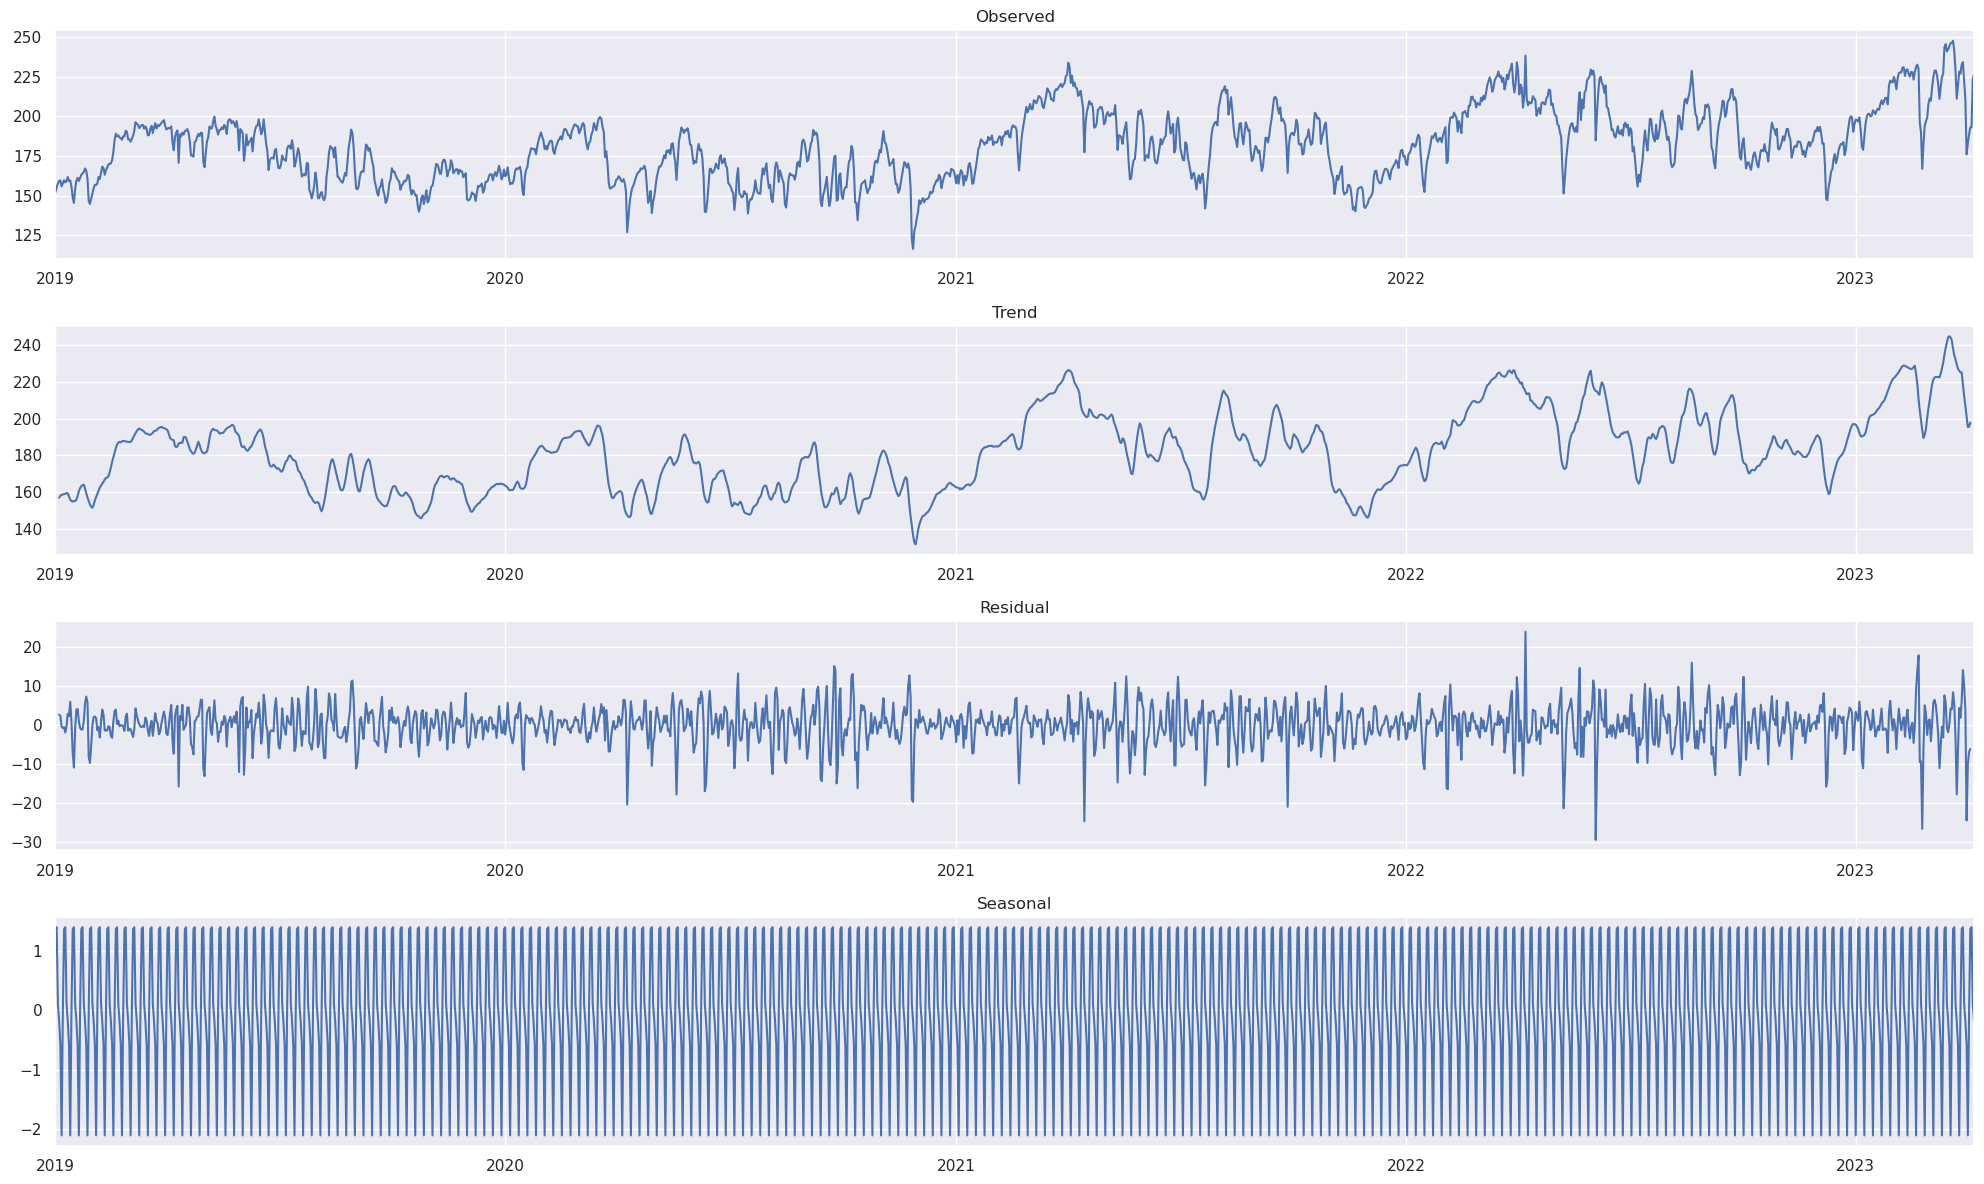

In [644]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [645]:
y = merged_df['Energy Required (MU)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -3.951004
p-value: 0.001690
#Lags used: 15
Critical Value (1%): -3.434598
Critical Value (5%): -2.863416
Critical Value (10%): -2.567769


The **ADF statistic** (-3.951004) is less than the critical value at 5% (-2.863416) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is **either stationary or could be made stationary** with 1st order differencing (difference-stationary).

In [646]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print(f'Critical value ({key}): {value}')


KPSS Statistic: 1.972154
p-value: 0.010000
#Lags used: 25
Critical value (10%): 0.347
Critical value (5%): 0.463
Critical value (2.5%): 0.574
Critical value (1%): 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The **KPSS statistic (1.972154)** is higher than the critical value at 5% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 5%**, meaning that the **time series is stationary **or stationary around a constant.

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


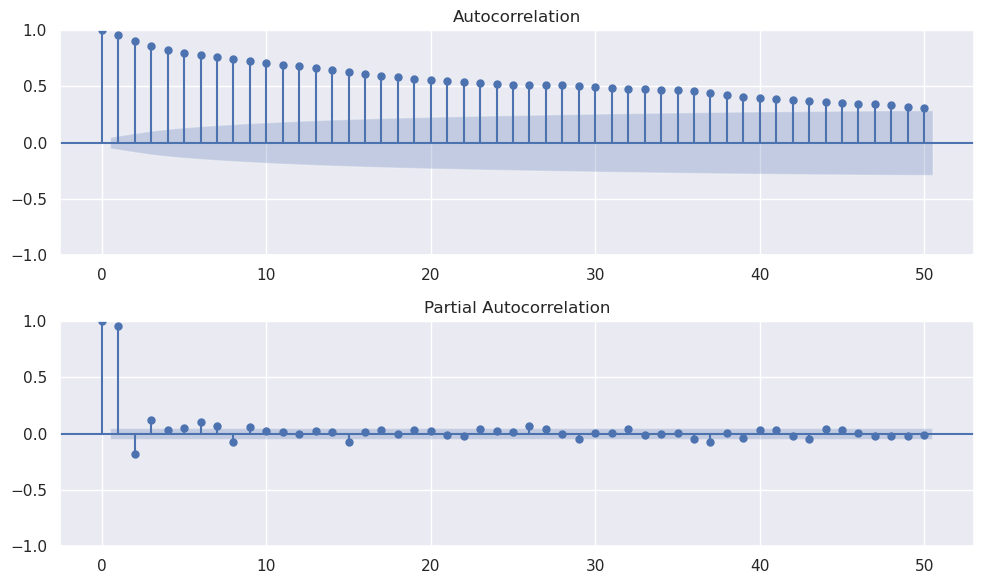

In [647]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(merged_df['Energy Required (MU)'], lags=50, ax=ax1)
plot_pacf(merged_df['Energy Required (MU)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

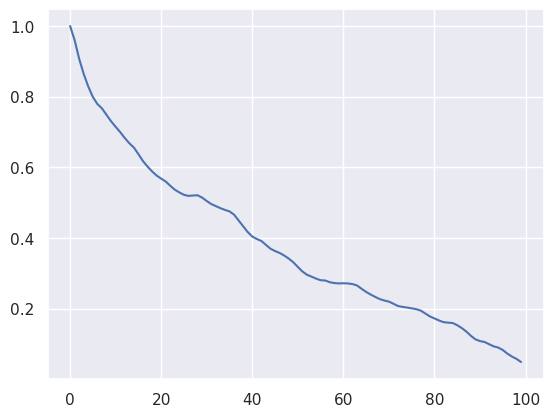

In [648]:
cross_corr = ccf(merged_df['Energy Required (MU)'], merged_df['Energy Required (MU)'])
plt.plot(cross_corr[0:100])
plt.show()

In [649]:
correlations = merged_df.corr(method='pearson')
print(correlations['Energy Required (MU)'].sort_values(ascending=False).to_string())

Energy Required (MU)    1.000000
Tmax                    0.336400
Tmin                    0.081247
Rain                   -0.256393


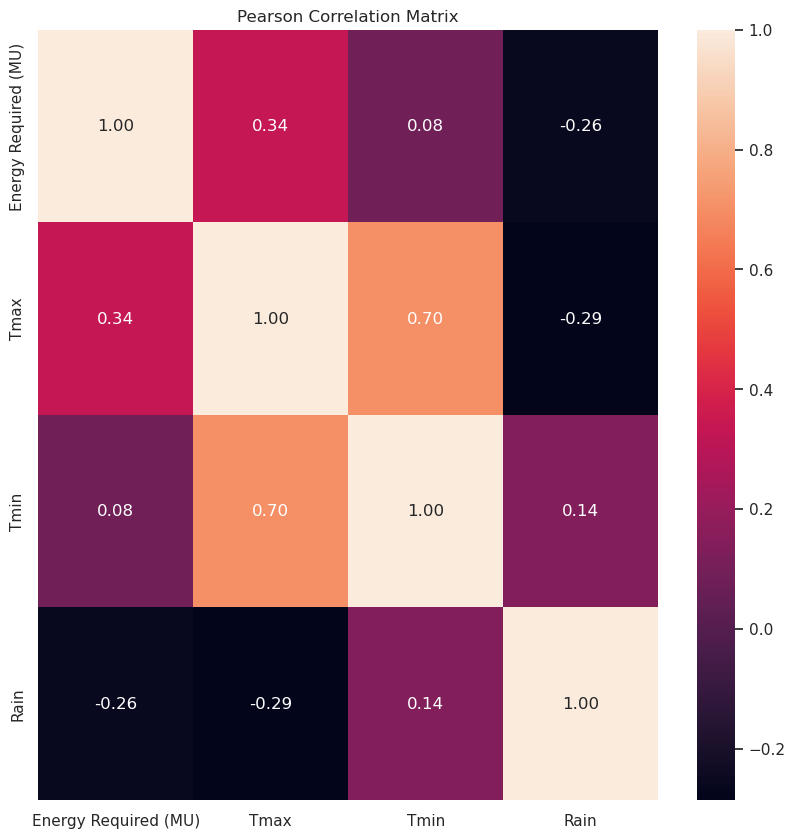

In [650]:

correlations = merged_df.corr(method='pearson')
fig = plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [651]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Series([], )


In [652]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [653]:
X.shape

(1558, 4)

In [654]:
train_end_idx = 1200
cv_end_idx = 1396
test_end_idx = 1557

In [655]:
X = merged_df.values
y = merged_df['Energy Required (MU)'].values

In [656]:
X

array([[152.233     ,  28.69680159,  14.07012138,   0.        ],
       [155.343     ,  29.40800289,  18.14846943,   0.        ],
       [157.659     ,  33.18452609,  23.71441105,   1.55000675],
       ...,
       [193.201     ,  33.9343353 ,  25.92819331,   2.54157166],
       [224.03      ,  38.14582355,  27.39860641,   0.        ],
       [226.349     ,  39.62275041,  27.56807882,   0.        ]])

In [657]:

y = y.reshape(-1, 1)
y

array([[152.233],
       [155.343],
       [157.659],
       ...,
       [193.201],
       [224.03 ],
       [226.349]])

In [662]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [663]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [664]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [665]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if start_index==0:
        start_index = start_index + history_size
    else:
        start_index=start_index
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [761]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)
n_features = 4
past_history = 28
future_target = 1

In [667]:
dataset_norm.shape

(1558, 5)

In [668]:
X_train, y_train = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [669]:
X_train.shape

(1172, 28, 4)

In [670]:
X_val, y_val = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [671]:
X_val.shape

(196, 28, 4)

In [672]:
y_val.shape

(196,)

In [673]:
X_test, y_test = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [674]:
X_test.shape

(161, 28, 4)

In [675]:
batch_size = 32
buffer_size = 1000

In [676]:
X_train.shape

(1172, 28, 4)

In [677]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [682]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [683]:
y_test

array([[0.62140188],
       [0.51850698],
       [0.51421218],
       [0.5332847 ],
       [0.55178349],
       [0.58242082],
       [0.5607747 ],
       [0.59055964],
       [0.6202708 ],
       [0.6202708 ],
       [0.58420759],
       [0.56661858],
       [0.4720756 ],
       [0.49577897],
       [0.52704741],
       [0.53399777],
       [0.52703101],
       [0.55593895],
       [0.55384073],
       [0.55268507],
       [0.5264081 ],
       [0.48773031],
       [0.50672087],
       [0.47523933],
       [0.50827815],
       [0.53465347],
       [0.55353747],
       [0.53074389],
       [0.55102124],
       [0.55643073],
       [0.58522392],
       [0.61206642],
       [0.60770605],
       [0.63105698],
       [0.60860763],
       [0.63129467],
       [0.59599371],
       [0.54513638],
       [0.54486591],
       [0.4379303 ],
       [0.25857321],
       [0.2519261 ],
       [0.32135598],
       [0.35198512],
       [0.40044095],
       [0.41098944],
       [0.46410071],
       [0.490

In [684]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [685]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

# **Vanila LSTM**

In [686]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [687]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
37/37 [==============================] - 6s 48ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1497
Epoch 2/120
37/37 [==============================] - 1s 32ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
Epoch 3/120
37/37 [==============================] - 1s 32ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 4/120
37/37 [==============================] - 1s 34ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 5/120
37/37 [==============================] - 1s 33ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 6/120
37/37 [==============================] - 1s 32ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0170 - val_

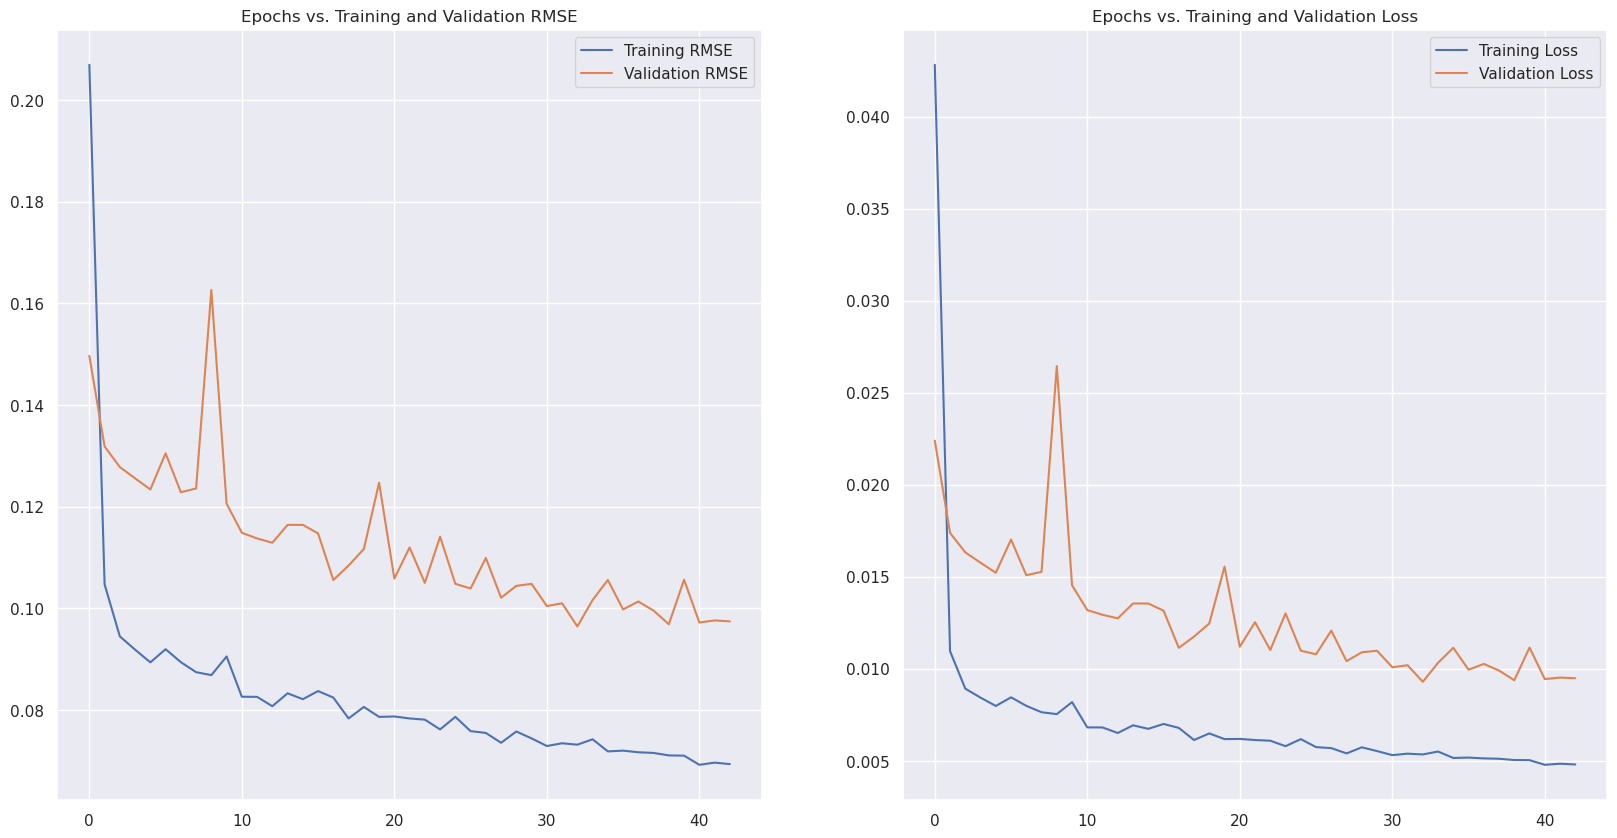

In [688]:
plot_model_rmse_and_loss(history)

In [729]:
X_test.shape

(161, 28, 4)

In [690]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of day ahead power demand LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

6/6 [==============================] - 0s 7ms/step
RMSE of day ahead power demand LSTM forecast: 12.199


In [694]:
merged_df.index[1368:1529]

DatetimeIndex(['2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03',
               '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
               '2022-10-08', '2022-10-09',
               ...
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08', '2023-03-09'],
              dtype='datetime64[ns]', length=161, freq='D')

In [697]:
len(lstm_forecast)

161

In [713]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

In [730]:
X_test2 = X[1530:1558,:].reshape(1,past_history,n_features)

In [731]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)

1/1 [==============================] - 0s 490ms/step


In [732]:
lstm_forecast_unseen

array([[1202.4436]], dtype=float32)

In [714]:
len(dates_forecasted)

161

In [741]:

# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

In [742]:
merged_df.tail(4)

,Energy Required (MU),Tmax,Tmin,Rain
2023-04-04,193.000,35.972310,25.309858,0.392332
2023-04-05,193.201,33.934335,25.928193,2.541572
2023-04-06,224.030,38.145824,27.398606,0.000000
2023-04-07,226.349,39.622750,27.568079,0.000000


In [744]:
extended_index[-1:]

DatetimeIndex(['2023-04-08'], dtype='datetime64[ns]', freq=None)

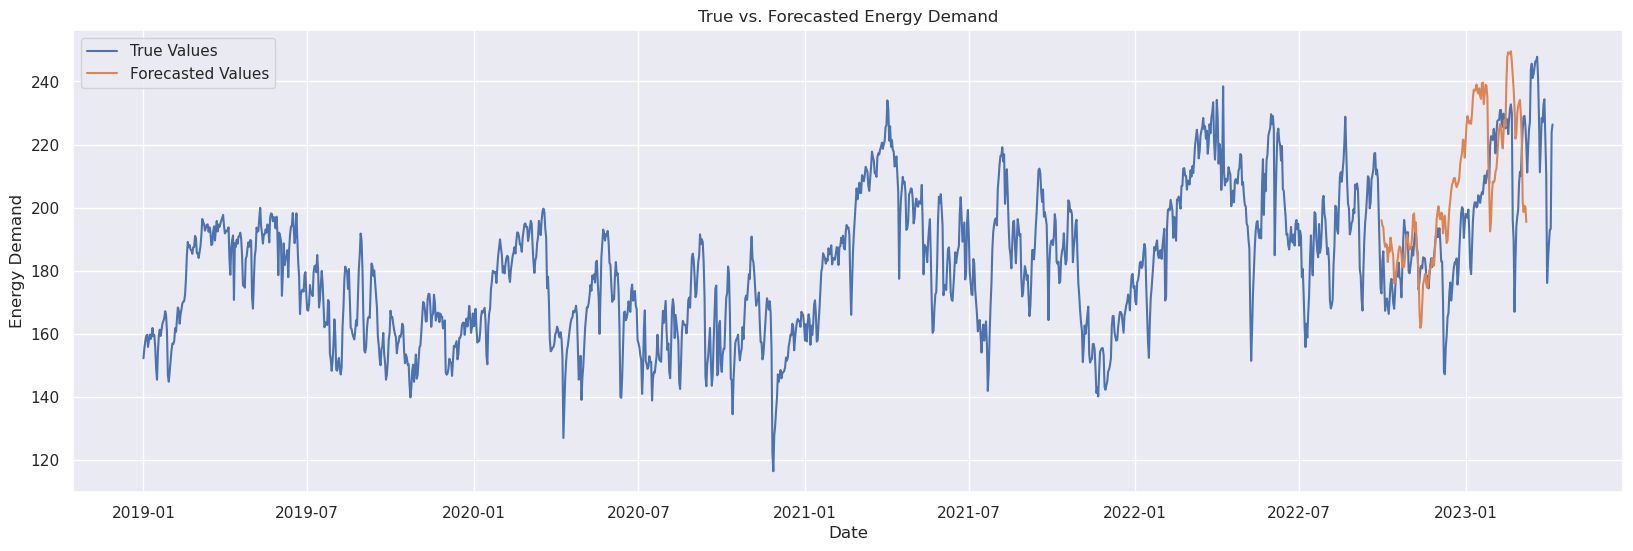

In [746]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted, lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Stacked LSTM**

In [747]:
tf.keras.backend.clear_session()

from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, LeakyReLU

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, return_sequences=True),
    LSTM(200, return_sequences=True),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(150),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [748]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
37/37 [==============================] - 21s 268ms/step - loss: 0.0400 - root_mean_squared_error: 0.1887 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1520
Epoch 2/120
37/37 [==============================] - 8s 218ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1458
Epoch 3/120
37/37 [==============================] - 8s 217ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 4/120
37/37 [==============================] - 8s 225ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1531
Epoch 5/120
37/37 [==============================] - 9s 230ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 6/120
37/37 [==============================] - 9s 255ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0243

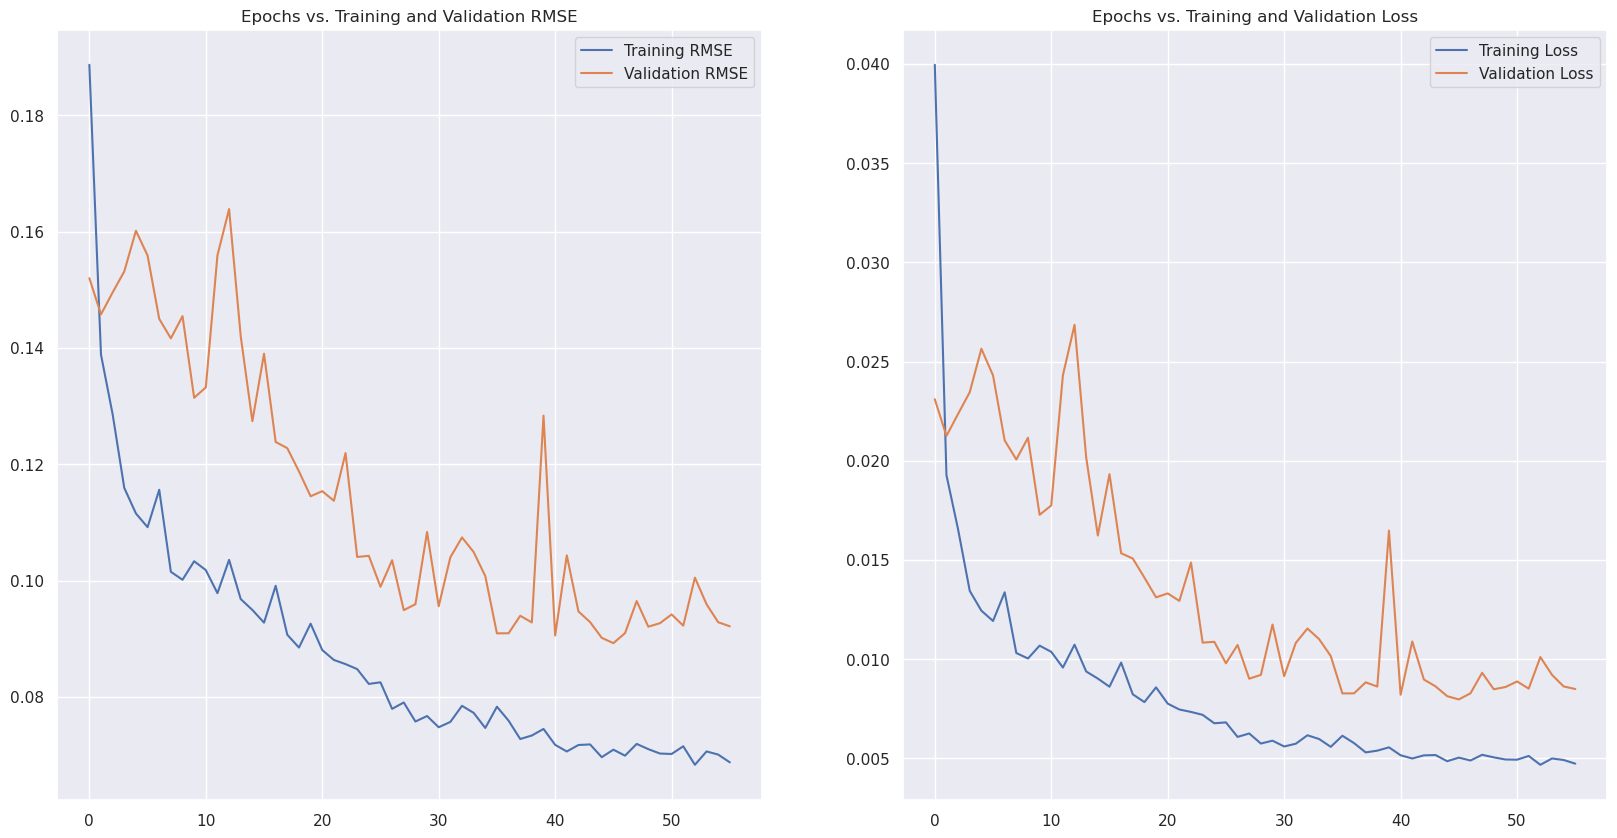

In [749]:
plot_model_rmse_and_loss(history)

In [750]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of day ahead power demand multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


6/6 [==============================] - 3s 66ms/step
RMSE of day ahead power demand multivariate Stacked LSTM forecast: 11.405


In [751]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

In [755]:
n_features = 4

In [756]:
X_test2 = X[1530:1558,:].reshape(1,past_history,n_features)

In [757]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)

1/1 [==============================] - 0s 482ms/step


In [758]:

# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

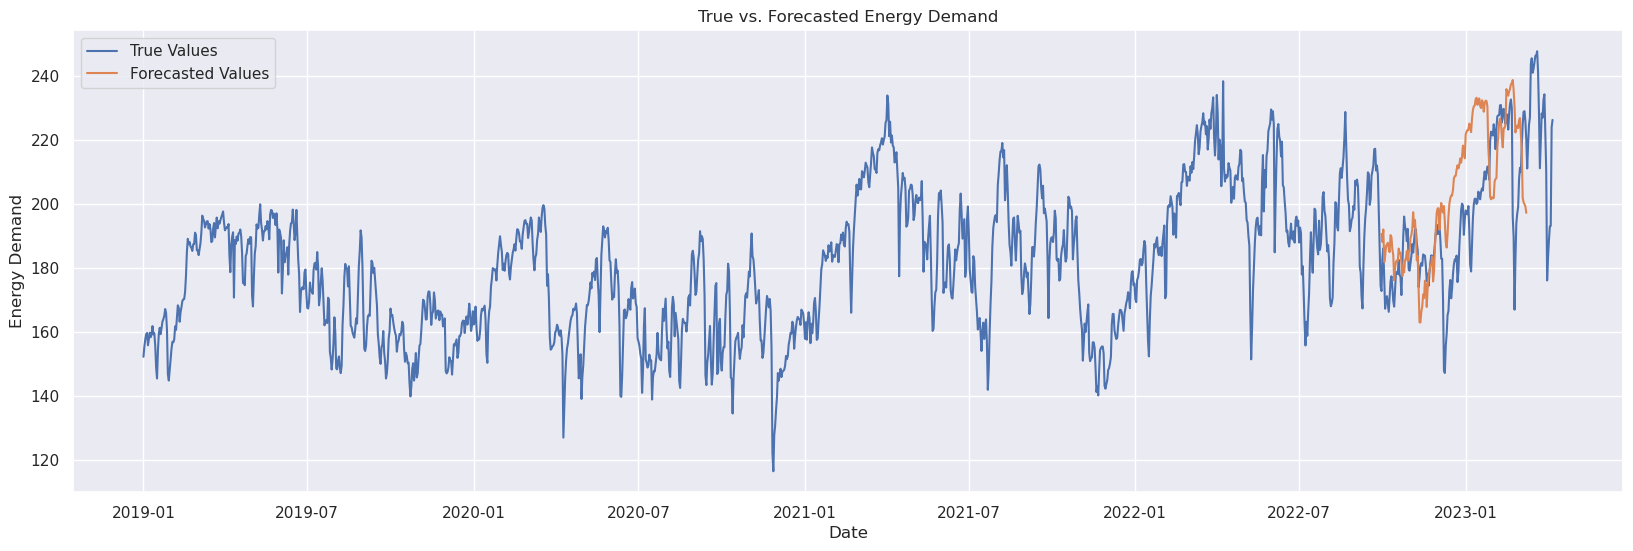

In [762]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted, multivariate_stacked_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN**

In [764]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [765]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
37/37 [==============================] - 1s 9ms/step - loss: 0.0503 - root_mean_squared_error: 0.2105 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 2/120
37/37 [==============================] - 0s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 3/120
37/37 [==============================] - 0s 4ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 4/120
37/37 [==============================] - 0s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 5/120
37/37 [==============================] - 0s 4ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 6/120
37/37 [==============================] - 0s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0146 - val_root_m

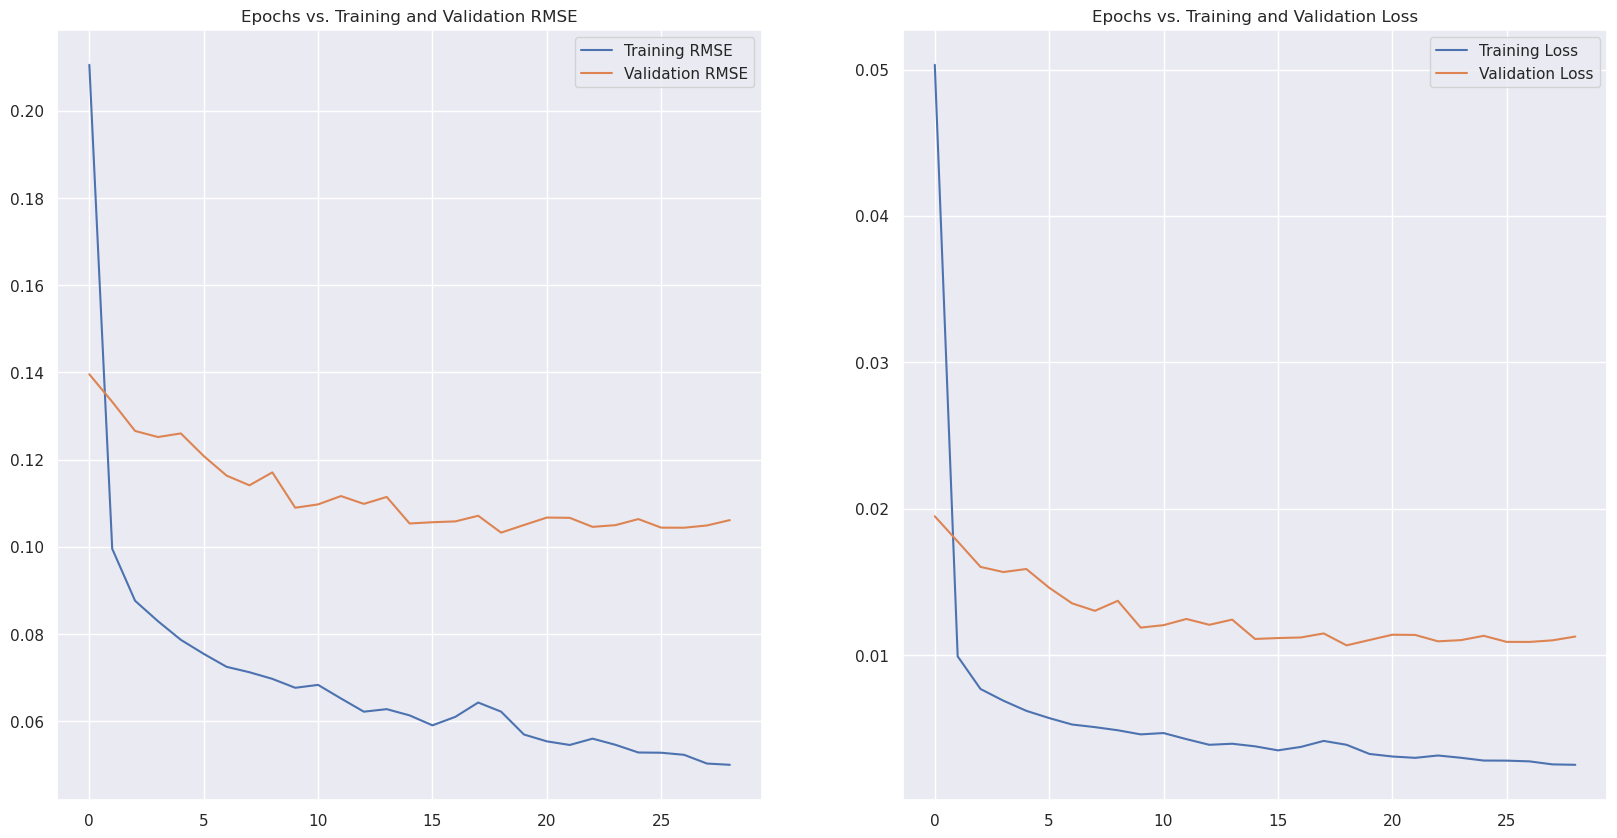

In [766]:
plot_model_rmse_and_loss(history)

In [767]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of day ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

6/6 [==============================] - 0s 3ms/step
RMSE of day ahead electricity price multivariate CNN forecast: 13.274


1/1 [==============================] - 1s 719ms/step


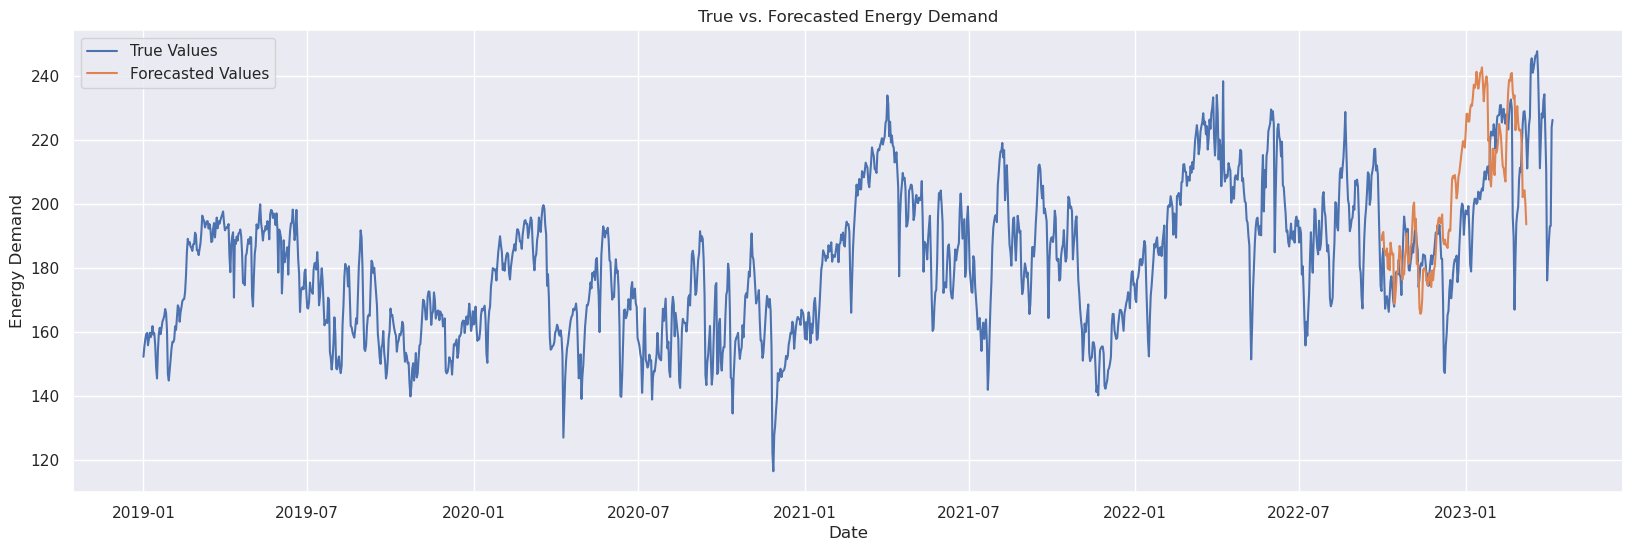

In [768]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted, multivariate_cnn_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN- LSTM**

In [769]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(100),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [770]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
37/37 [==============================] - 15s 171ms/step - loss: 0.0478 - root_mean_squared_error: 0.2064 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1500
Epoch 2/120
37/37 [==============================] - 4s 118ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 3/120
37/37 [==============================] - 4s 113ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1640
Epoch 4/120
37/37 [==============================] - 4s 107ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 5/120
37/37 [==============================] - 4s 114ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 6/120
37/37 [==============================] - 4s 107ms/step - loss: 0.0115 - root_mean_squared_error: 0.1070 - val_loss: 0.0197

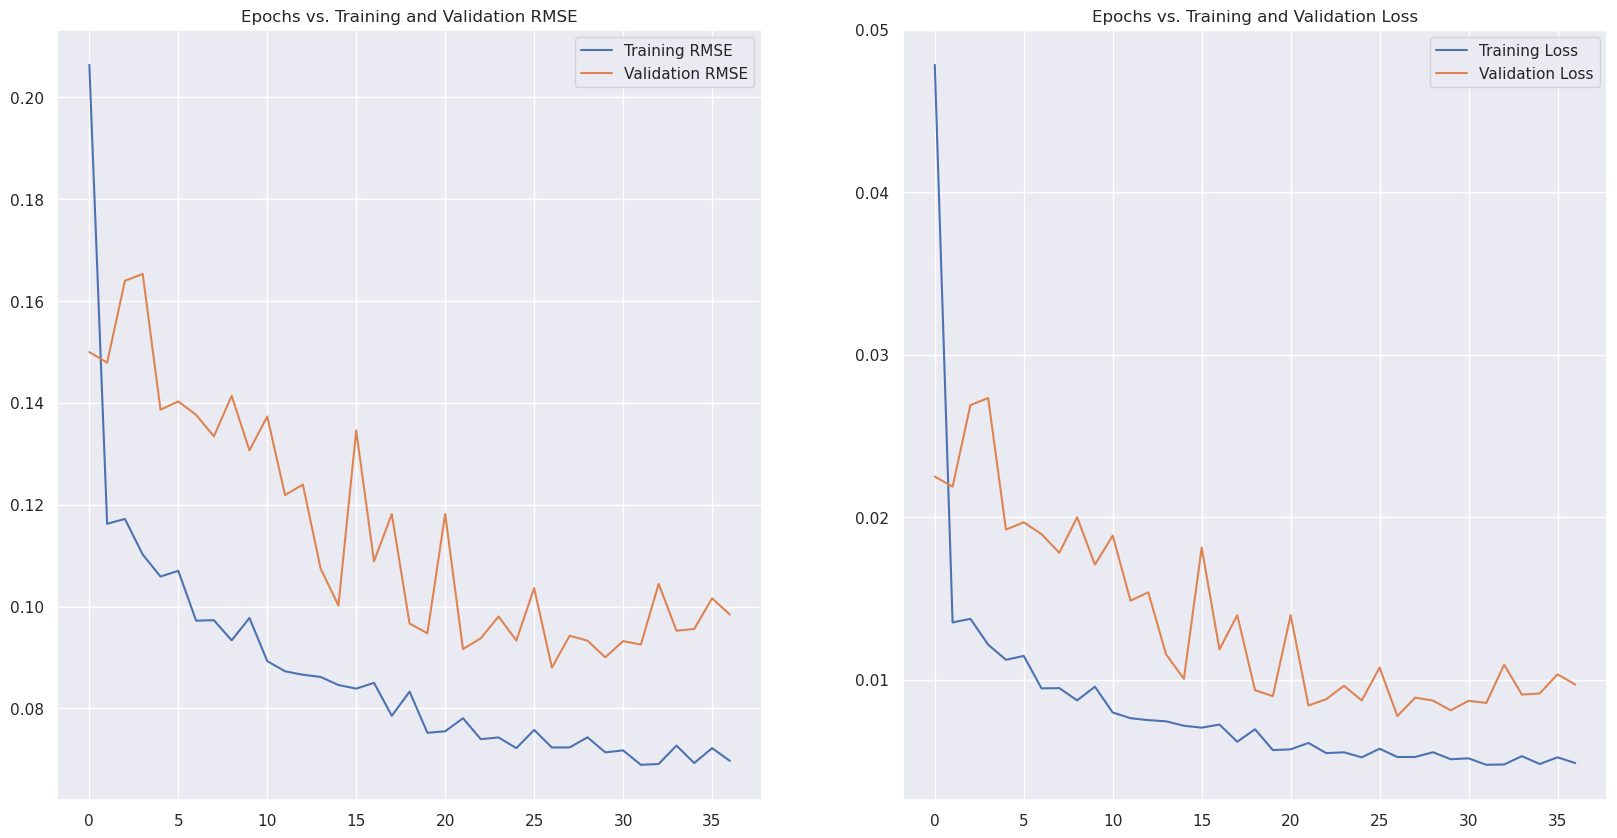

In [771]:
plot_model_rmse_and_loss(history)

In [772]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

6/6 [==============================] - 1s 26ms/step
RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: 11.166


1/1 [==============================] - 0s 452ms/step


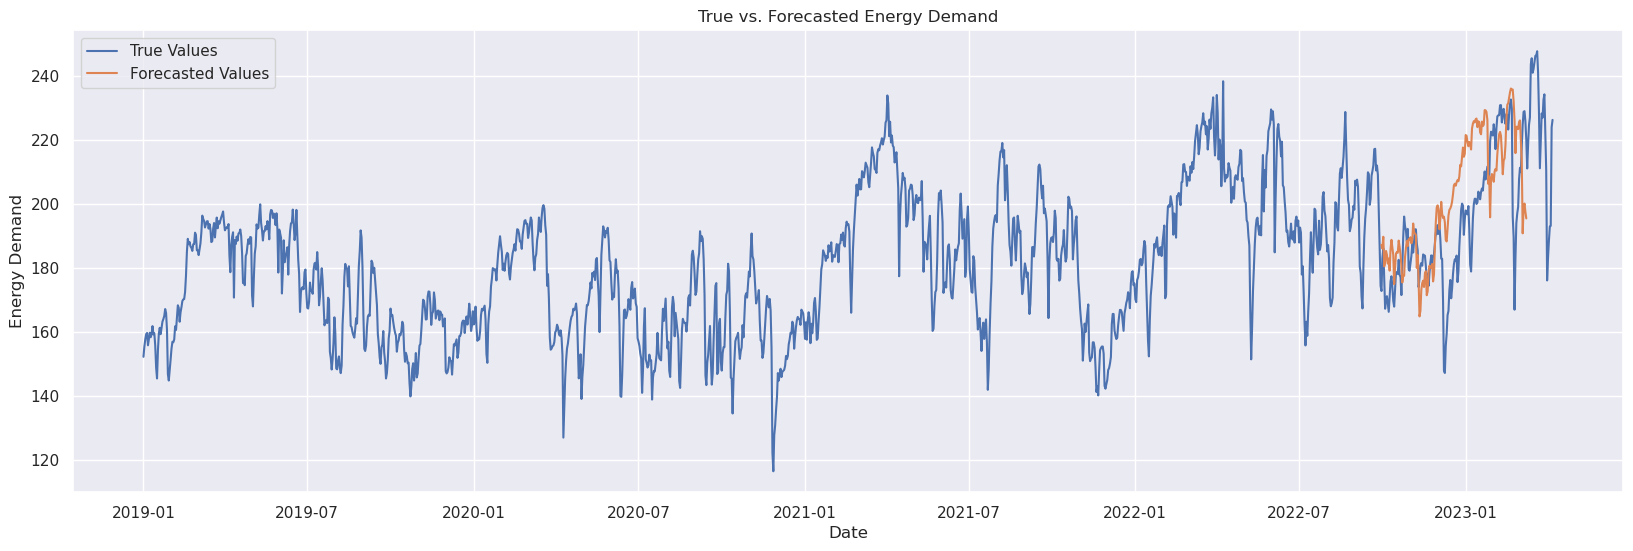

In [773]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted, multivariate_cnn_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Time Distributed MLP**

In [774]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [775]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
37/37 [==============================] - 2s 18ms/step - loss: 0.0261 - root_mean_squared_error: 0.1542 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 2/120
37/37 [==============================] - 1s 15ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 3/120
37/37 [==============================] - 1s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 4/120
37/37 [==============================] - 0s 11ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/120
37/37 [==============================] - 0s 12ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/120
37/37 [==============================] - 0s 11ms/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0146 - val_

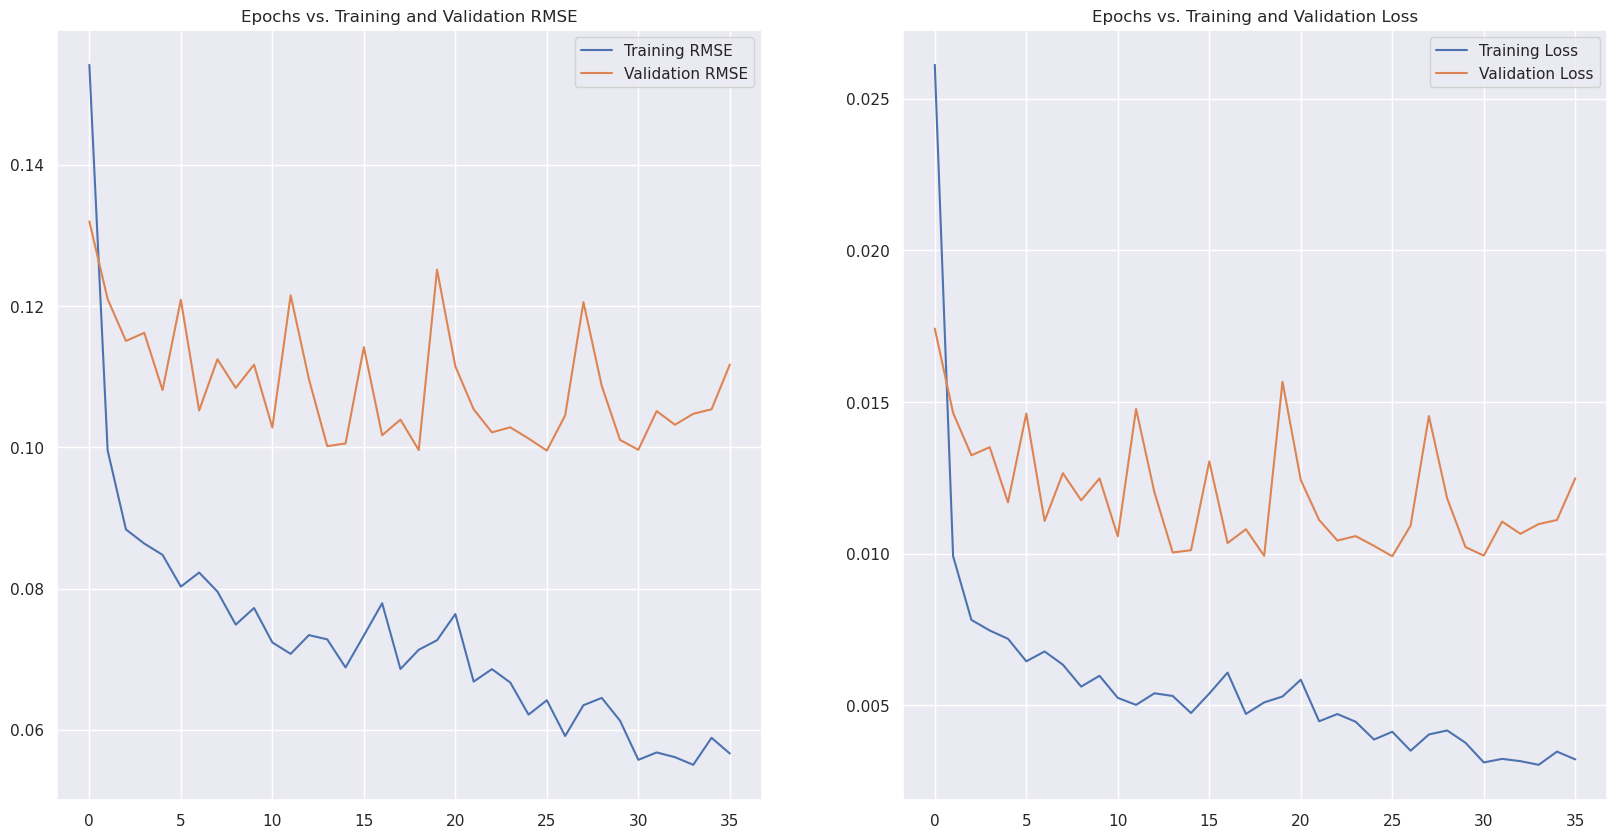

In [776]:
plot_model_rmse_and_loss(history)

In [777]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of day-ahead power demand multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

6/6 [==============================] - 0s 4ms/step
RMSE of day-ahead power demand multivariate MLP forecast: 12.725


1/1 [==============================] - 0s 448ms/step


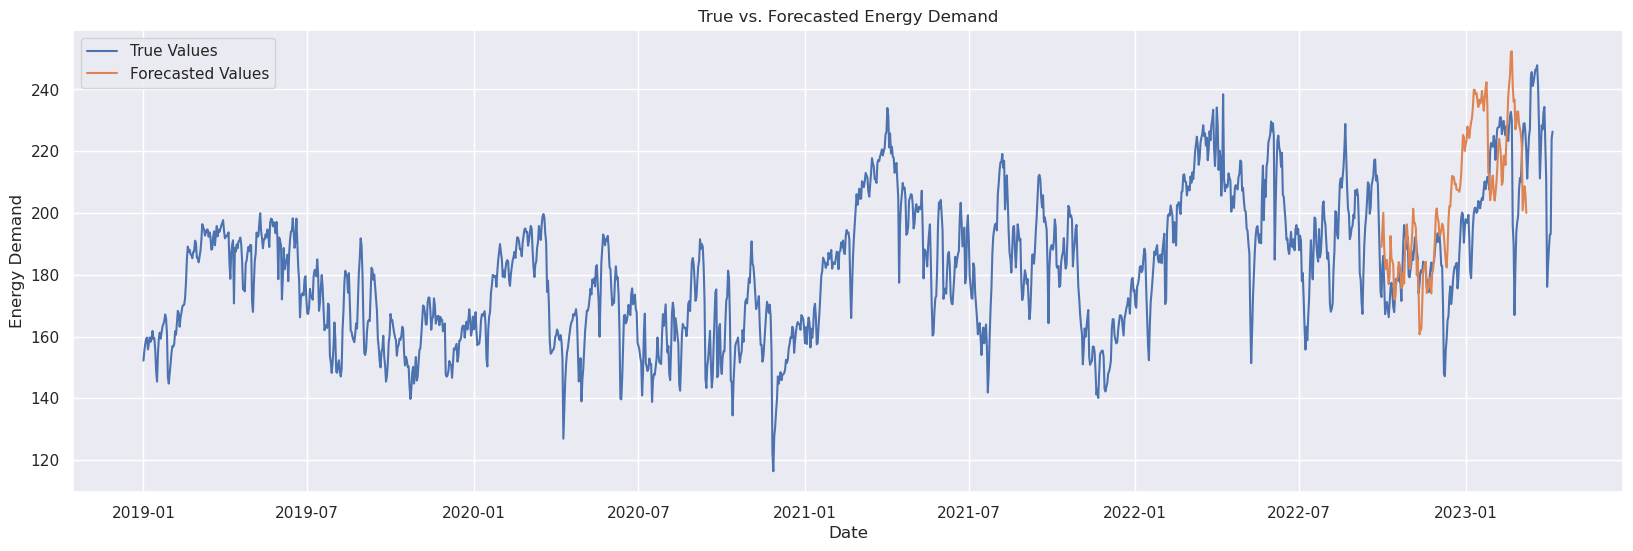

In [778]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted, multivariate_mlp_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Encoder Decoder**

In [789]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [790]:
history = encoder_decoder.fit(train, epochs=120,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/120
37/37 [==============================] - 5s 43ms/step - loss: 0.0406 - root_mean_squared_error: 0.1953 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1164
Epoch 2/120
37/37 [==============================] - 1s 31ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 3/120
37/37 [==============================] - 1s 31ms/step - loss: 0.0063 - root_mean_squared_error: 0.0797 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191
Epoch 4/120
37/37 [==============================] - 1s 32ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 5/120
37/37 [==============================] - 1s 33ms/step - loss: 0.0060 - root_mean_squared_error: 0.0771 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 6/120
37/37 [==============================] - 1s 33ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0111 - val_

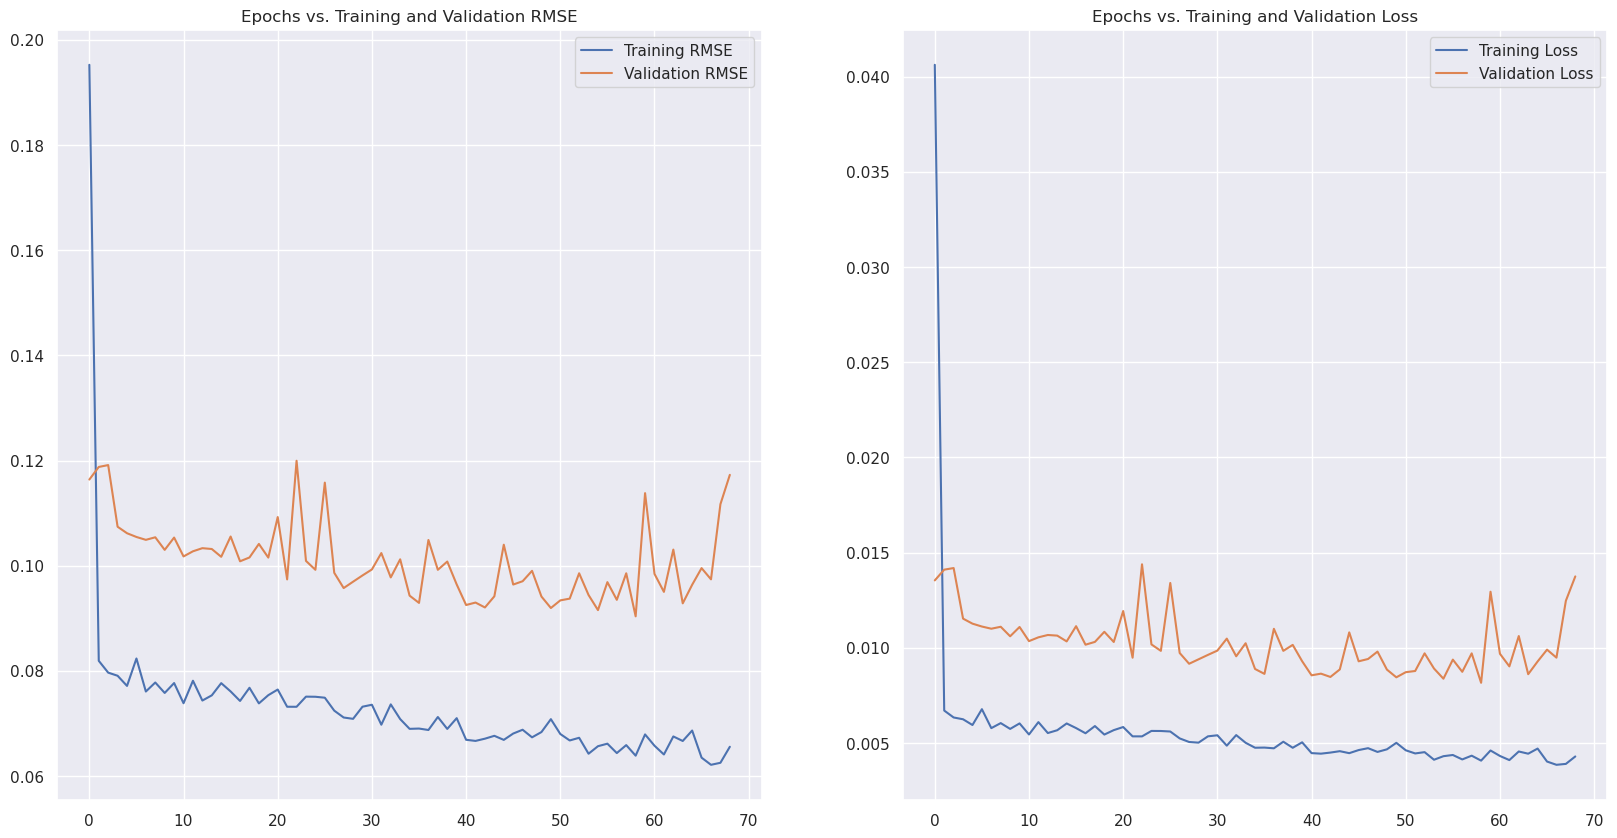

In [791]:
plot_model_rmse_and_loss(history)

In [792]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of day ahead power demand Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

6/6 [==============================] - 0s 8ms/step
RMSE of day ahead power demand Encoder-Decoder forecast: 12.205


1/1 [==============================] - 0s 470ms/step


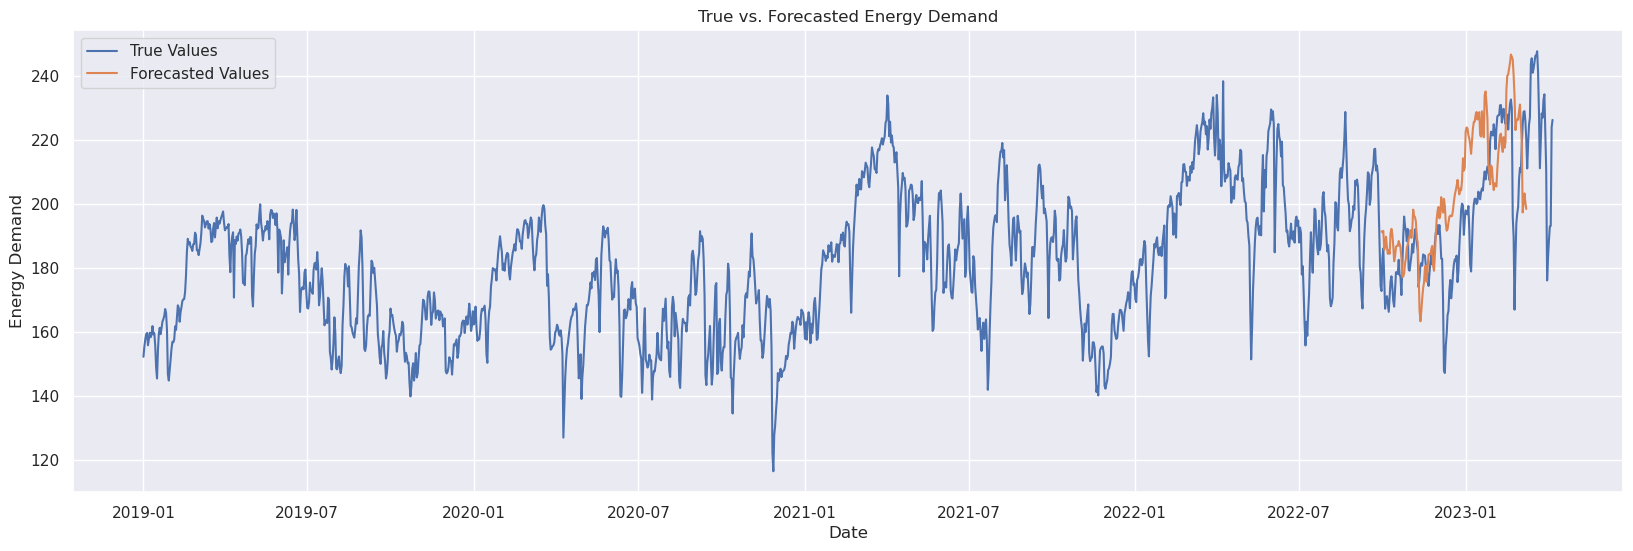

In [793]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, y[:1559], label='True Values')
plt.plot(dates_forecasted,encoder_decoder_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **GluonTS**

In [391]:
!pip install "gluonts[torch]"

ERROR: Could not find a version that satisfies the requirement gluonts[torch] (from versions: none)
ERROR: No matching distribution found for gluonts[torch]


In [426]:
!pip install mxnet
!pip install gluonts

ERROR: Could not find a version that satisfies the requirement mxnet (from versions: none)
ERROR: No matching distribution found for mxnet
^C


In [425]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

ModuleNotFoundError: No module named 'gluonts'